In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark.conf.set("spark.sql.caseSensitive", True) # Avoid error "Found duplicate column(s) in the data schema"
spark

In [ ]:
import json
import pandas as pd

def parse(path):
    with open(path, 'r') as f:
        for line in f:
            yield json.loads(line)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Now read in the data
df = getDF("Sports_and_Outdoors_5.json")


In [ ]:
df

In [ ]:
df.to_csv('Sports_and_Outdoors_5.csv')

In [ ]:
first = df.iloc[:150000]
second = df.iloc[-150000:]

# Save the two halves to CSV files
first.to_csv('first_1.csv', index=False)
second.to_csv('second_1.csv', index=False)

In [ ]:
len(df)

2839940

In [ ]:
# Group the data by reviewerID and count the occurrences
reviewer_counts = df.groupby("reviewerID").size().reset_index(name="count")

# Sort the DataFrame by count in descending order
reviewer_counts = reviewer_counts.sort_values(by="count", ascending=False)

# Print the resulting DataFrame
print(reviewer_counts)

            reviewerID  count
236287  A3OXHLG6DIBRW8    371
322216   AVU1ILDDYW301    341
301110   AN81JUYW2SL24    313
320257   AV0B6NGGOAISO    278
265995   A8VI7KMUHI7ZH    261
...                ...    ...
244032  A3S3B18E6T73XJ      3
195099  A384HNK4R4FFPC      3
50975   A1KW0HFDPC4YLC      3
115208   A2BDUVU6JHHP9      2
232993  A3NKE1UXKR8TLV      2

[332447 rows x 2 columns]


In [ ]:
def get_sentiment(overall):
    if overall == 5.0 or overall == 4.0:
        return "positive"
    else:
        return "negative"

# Apply the function to create a new column called "sentiment"
df["sentiment"] = df["overall"].apply(get_sentiment)

# Print the resulting dataframe
print(df.head())

   overall  verified   reviewTime      reviewerID        asin    reviewerName  \
0      5.0      True   06 3, 2015  A180LQZBUWVOLF  0000032034      Michelle A   
1      1.0      True   04 1, 2015   ATMFGKU5SVEYY  0000032034       Crystal R   
2      5.0      True  01 13, 2015  A1QE70QBJ8U6ZG  0000032034  darla Landreth   
3      5.0      True  12 23, 2014  A22CP6Z73MZTYU  0000032034        L. Huynh   
4      4.0      True  12 15, 2014  A22L28G8NRNLLN  0000032034         McKenna   

                                          reviewText  \
0            What a spectacular tutu! Very slimming.   
1  What the heck? Is this a tutu for nuns? I know...   
2                  Exactly what we were looking for!   
3  I used this skirt for a Halloween costume and ...   
4  This is thick enough that you can't see throug...   

                                             summary  unixReviewTime style  \
0                                         Five Stars      1433289600   NaN   
1                   

In [ ]:
df["sentiment"] = df["overall"].apply(get_sentiment)

# Group the dataframe by the asin and sentiment columns, and get the count of each group
grouped_df = df.groupby(["asin", "sentiment"]).size().reset_index(name="count")

# Pivot the grouped dataframe to get the count of positive and negative sentiment for each asin
pivoted_df = grouped_df.pivot(index="asin", columns="sentiment", values="count").reset_index()

# Fill any missing values with 0
pivoted_df = pivoted_df.fillna(0)

pivoted_df["total_count"] = pivoted_df["positive"] + pivoted_df["negative"]
pivoted_df_total = pivoted_df.sort_values(by="total_count", ascending=False)

# Print the resulting dataframe
print(pivoted_df_total)

sentiment        asin  negative  positive  total_count
10920      B0010O748Q     968.0    3195.0       4163.0
11496      B0012Q2S4W     813.0    2574.0       3387.0
12718      B0014VX2M2     296.0    2894.0       3190.0
12926      B0015LT03G     692.0    2456.0       3148.0
12929      B0015LY0DG     696.0    2450.0       3146.0
...               ...       ...       ...          ...
11666      B001348XVK       0.0       1.0          1.0
9898       B000WUG52U       1.0       0.0          1.0
12639      B0014S4EPO       0.0       1.0          1.0
12637      B0014RZ4WM       0.0       1.0          1.0
12113      B0013T9BNO       0.0       1.0          1.0

[104687 rows x 4 columns]


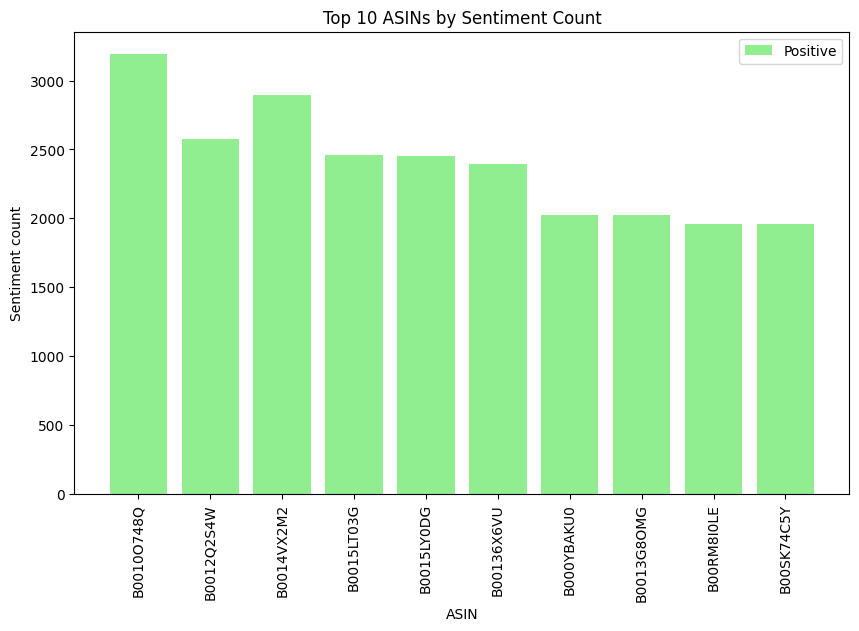

In [ ]:
 import matplotlib.pyplot as plt
# Select the top 5 ASINs by sentiment count
top_10_df = pivoted_df_total.head(10)

# Create a vertical bar chart
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(top_10_df["asin"], top_10_df["positive"], color="lightgreen", label="Positive")

# Add labels and title
ax.set_xlabel("ASIN")
ax.set_ylabel("Sentiment count")
ax.set_title("Top 10 ASINs by Sentiment Count")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a legend
ax.legend()

plt.show()


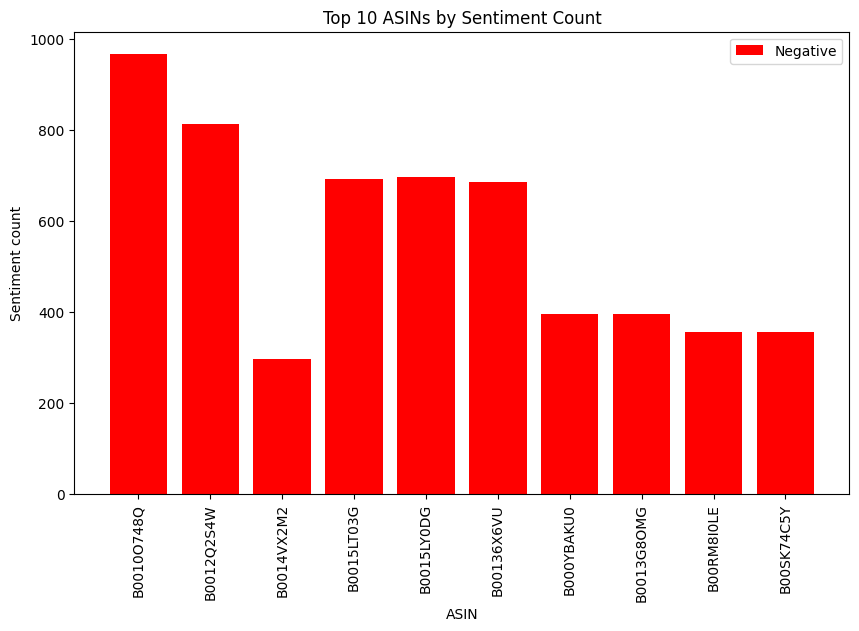

In [ ]:
# Select the top 5 ASINs by sentiment count
top_10_df = pivoted_df_total.head(10)

# Create a vertical bar chart
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(top_10_df["asin"], top_10_df["negative"], color="red", label="Negative")

# Add labels and title
ax.set_xlabel("ASIN")
ax.set_ylabel("Sentiment count")
ax.set_title("Top 10 ASINs by Sentiment Count")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a legend
ax.legend()

plt.show()

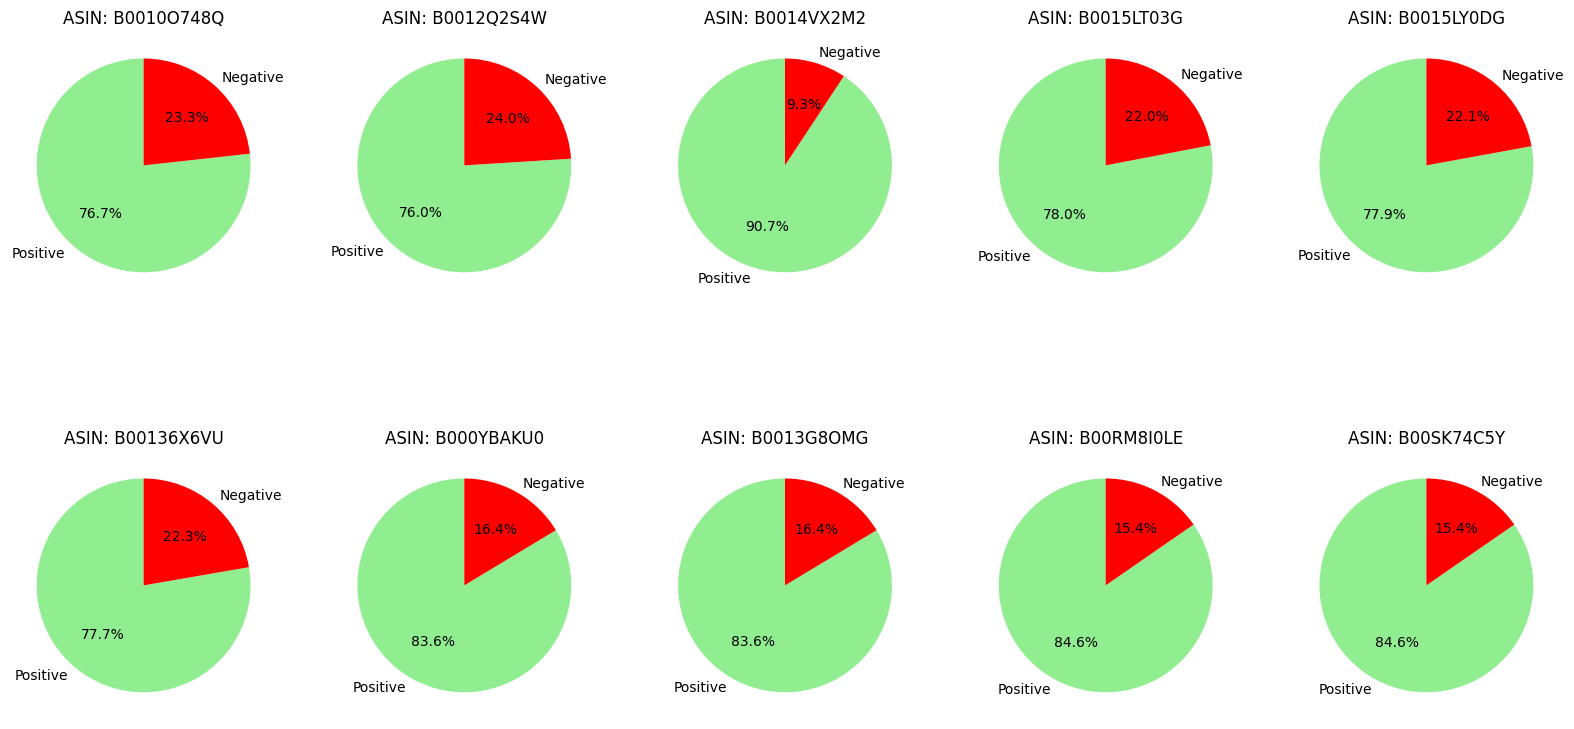

In [ ]:
# Select the top 10 ASINs by sentiment count
import matplotlib.pyplot as plt
top_10_df = pivoted_df_total.head(10)

# Set up a 2x5 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Loop over the top 10 ASINs and create a pie chart for each
for i, asin in enumerate(top_10_df["asin"]):
    # Get the positive and negative sentiment counts for the ASIN
    pos_count = top_10_df.loc[top_10_df["asin"] == asin, "positive"].iloc[0]
    neg_count = top_10_df.loc[top_10_df["asin"] == asin, "negative"].iloc[0]

    # Create a pie chart
    labels = ["Positive", "Negative"]
    sizes = [pos_count, neg_count]
    colors = ["lightgreen", "red"]
    axs[i].pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
    axs[i].set_title(f"ASIN: {asin}")

# Remove unused subplots
for i in range(len(top_10_df), len(axs)):
    fig.delaxes(axs[i])

plt.show()

In [ ]:
# Specify the reviewerID you're interested in
target_reviewerID = "A180LQZBUWVOLF"

# Filter the dataset to only include rows with the target reviewerID
target_reviews = df[df["reviewerID"] == target_reviewerID]

# Select the asin column from the filtered dataset
target_asins = target_reviews["asin"]

# Convert the resulting pandas Series object to a Python list
asin_list = list(target_asins)

# Print the resulting list
print(asin_list)

['0000032034', 'B00EPGLIOM', 'B00FFADO8A', 'B01AHC75PS', 'B001OPH87I']


In [ ]:
len(asin_list)

5

In [ ]:
myreview = spark.read.json("Digital_Music_5.json")
myreview

asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
3426958910,null,5.0,This is awesome t...,"06 3, 2013",A2TYZ821XXK2YZ,Garrett,{ Audio CD},Slayer Rules!,1370217600,true,3
3426958910,null,5.0,bien,"10 11, 2014",A3OFSREZADFUDY,Ad,{ Audio CD},Five Stars,1412985600,true,null
3426958910,null,5.0,It was great to h...,"02 11, 2014",A2VAMODP8M77NG,JTGabq,{ Audio CD},SLAYER!!!!!!!!!!!...,1392076800,true,null
3426958910,null,4.0,well best of's ar...,"12 7, 2013",AAKSLZ9IDTEH0,john F&#039;n doe,{ Audio CD},slayer greatest h...,1386374400,false,3
5557706259,null,5.0,What can I say? T...,"06 12, 2016",A3OH43OZJLKI09,melinda a goodman,{ Audio CD},"This is a good, b...",1465689600,true,null
5557706259,null,4.0,Enjoy Casting Cro...,"11 19, 2015",A6JP9YYJCK3WO,Sylvia Arrowood,{ Audio CD},Four Stars,1447891200,true,null
5557706259,null,5.0,Another very insp...,"06 6, 2015",A20Z0JD766DPG6,M Holley,{ Audio CD},Can't say enough....,1433548800,true,null
5557706259,null,5.0,I love the song S...,"12 9, 2008",AXQ89O6YRT7AX,PacificHype,{ MP3 Music},DEFINITELY DESERV...,1228780800,false,null
5557706259,null,5.0,This is an awesom...,"10 7, 2008",A1M379MK8MKGUF,Sergio,{ MP3 Music},Can't go wrong wi...,1223337600,false,null
5557706259,null,5.0,I can't believe I...,"09 3, 2008",AA762OWLWCPQ2,Daniel T. Hughes,{ Audio CD},"Great music, but ...",1220400000,false,null


In [ ]:
myreview_column=myreview.select('asin')
unique_asin=myreview_column.distinct()
unique_asin

asin
B000SZLAVK
B000TDYS56
B000VRWVLI
B000W1O23I
B000YOIQEY
B0012422HM
B0012EELIK
B00136JC4U
B00137IL5U
B00137IN62


In [ ]:
unique_asin_count=myreview_column.distinct().count()
print("Number of unique ASIN values:", unique_asin_count)

Number of unique ASIN values: 11797


In [ ]:
# More operations are available from Spark's SQL functions
from pyspark.sql import functions as f

In [ ]:
mydata=myreview.withColumn(
    "sentiments",
    f.when((f.col("overall")>=4),"positive")
    .when((f.col("overall")<=2),"negative")
)

In [ ]:
mydata = (mydata
          #Remove handles
          .withColumn("reviewText", f.regexp_replace(f.col("reviewText"), "@[\w]*", ""))
          #Remove special characters
          .withColumn("reviewText", f.regexp_replace(f.col("reviewText"), "[^a-zA-Z']", " "))
          #Remove leading and trailing whitespaces
          .withColumn("reviewText", f.trim(f.col("reviewText")))
          #Restrict the length of the string
          .filter(f.length("reviewText")>50)
          )

mydata.show(5)

+----------+-----+-------+--------------------+-----------+--------------+-----------------+-----------+--------------------+--------------+--------+----+----------+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|     reviewerName|      style|             summary|unixReviewTime|verified|vote|sentiments|
+----------+-----+-------+--------------------+-----------+--------------+-----------------+-----------+--------------------+--------------+--------+----+----------+
|3426958910| null|    5.0|This is awesome t...| 06 3, 2013|A2TYZ821XXK2YZ|          Garrett|{ Audio CD}|       Slayer Rules!|    1370217600|    true|   3|  positive|
|3426958910| null|    5.0|It was great to h...|02 11, 2014|A2VAMODP8M77NG|           JTGabq|{ Audio CD}|SLAYER!!!!!!!!!!!...|    1392076800|    true|null|  positive|
|3426958910| null|    4.0|well best of's ar...| 12 7, 2013| AAKSLZ9IDTEH0|john F&#039;n doe|{ Audio CD}|slayer greatest h...|    1386374400|   false|   3|  positive|
|555

In [ ]:
mydataPos = mydata.filter("sentiments= 'positive'")

# Get the negative ones
mydataNeg = mydata.filter("sentiments = 'negative'")

mydataPossample = mydataPos.sample(fraction=83000/mydataPos.count(), seed=9165)

# Get a random sample from negative
mydataNegsample = mydataNeg.sample(fraction=3000/mydataNeg.count(), seed=9165)

In [ ]:
mysample = mydataPossample.union(mydataNegsample)

In [ ]:
mysample.groupBy("sentiments").count()

sentiments,count
positive,83039
negative,3008


In [ ]:
(training, test) = mysample.randomSplit([0.67, 0.33],seed = 9165)

In [ ]:
training.groupBy("sentiments").count()

sentiments,count
positive,55543
negative,1993


In [ ]:
test.groupBy("sentiments").count()

sentiments,count
positive,27496
negative,1015


In [ ]:
# More operations are available from Spark's SQL functions
from pyspark.sql import functions as f

# Use nickname feat for the subpackage
import pyspark.ml.feature as feat

# We need Pipeline to streamline the workflow
from pyspark.ml import Pipeline

# Use logistic regression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes

# Import an evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Additional functions for tuning parameters
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
splitter = feat.RegexTokenizer(
    inputCol='reviewText'
    , outputCol='reviewText_split'
    , pattern='\s+'
)

# Remove stop words
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='reviewText_noSW'
)

# Count word frequency
count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='features'
    , vocabSize=3000
)



# Prepare the target variable
label_string = feat.StringIndexer(
    inputCol = "sentiments"
    , outputCol = "label"
)


# Logistic regression model
lr = LogisticRegression(
    maxIter=100
)


# Finally set up the pipline
sentiments_pipeline_bow = Pipeline(
    stages=[
            splitter
            , sw_remover
            , count_vec
            , label_string
            , lr
            ]
)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lrModel = sentiments_pipeline_bow.fit(training)
lr_prediction = lrModel.transform(test)
lr_prediction.select("prediction", "sentiments", "features").show(50)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

+----------+----------+--------------------+
|prediction|sentiments|            features|
+----------+----------+--------------------+
|       0.0|  positive|(3000,[7,18,26,20...|
|       0.0|  positive|(3000,[0,1,2,4,5,...|
|       0.0|  positive|(3000,[45,59,117,...|
|       0.0|  positive|(3000,[0,1,3,4,6,...|
|       0.0|  positive|(3000,[2,3,4,6,11...|
|       0.0|  positive|(3000,[0,1,3,4,6,...|
|       0.0|  positive|(3000,[4,7,16,18,...|
|       0.0|  positive|(3000,[0,1,2,7,13...|
|       0.0|  positive|(3000,[0,4,6,10,1...|
|       0.0|  positive|(3000,[0,5,6,7,9,...|
|       0.0|  positive|(3000,[1,3,7,12,1...|
|       0.0|  positive|(3000,[1,7,9,10,1...|
|       0.0|  positive|(3000,[1,4,6,10,1...|
|       0.0|  positive|(3000,[18,21,35,4...|
|       0.0|  positive|(3000,[0,1,2,4,5,...|
|       0.0|  positive|(3000,[16,41,65,1...|
|       0.0|  positive|(3000,[1,15,26,42...|
|       0.0|  positive|(3000,[7,11,13,18...|
|       0.0|  positive|(3000,[7,11,13,18...|
|       0.

In [ ]:
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of this Logistic Regression model with bag-of-words approach is %g"% (lr_accuracy))

Accuracy of this Logistic Regression model with bag-of-words approach is 0.964645


In [ ]:
# Build up the pipeline/workflow for Logistic Regression

# Split the tweets into words
splitter = feat.RegexTokenizer(
    inputCol='reviewText'
    , outputCol='text_split'
    , pattern='\s+'
)

# Remove stop words
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='text_noSW'
)

# Count word frequency
count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
)

# Calculate IDF
idf_cal = feat.IDF(
    inputCol=count_vec.getOutputCol()
    , outputCol='features'
    , minDocFreq=500
)

# Prepare the target variable
label_string = feat.StringIndexer(
    inputCol = "sentiments"
    , outputCol = "label"
)

# Logistic Regression model
lr = LogisticRegression(
    maxIter=100
)


# Finally set up the pipline
sentiment_pipeline_idf_lr = Pipeline(
    stages=[
            splitter
            , sw_remover
            , count_vec
            , idf_cal
            , label_string
            , lr
            ]
)

In [ ]:
# Set up the parameters to tune
parGrid = ParamGridBuilder() \
          .addGrid(count_vec.vocabSize, [3000, 5000]) \
          .addGrid(lr.regParam, [0.1, 5]) \
          .build()

# Set up the cross validation
crossVal = CrossValidator(estimator=sentiment_pipeline_idf_lr,
                          estimatorParamMaps=parGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=10,
                          seed=9165)

In [ ]:
# Fit the process to the training data set
cvModel = crossVal.fit(training)

In [ ]:
# Summarise nicely the results of different parameter combinations

for i in range(len(cvModel.avgMetrics)):
  myParam = parGrid[i]
  myModel = "Model parameters: "
  for key, value in myParam.items():
    myModel += (key.name + '=' + str(value) + ' ')
  print(myModel+"has average accuracy: "+str(cvModel.avgMetrics[i]))

Model parameters: vocabSize=3000 regParam=0.1 has average accuracy: 0.9654554865366214
Model parameters: vocabSize=3000 regParam=5.0 has average accuracy: 0.9653682340265543
Model parameters: vocabSize=5000 regParam=0.1 has average accuracy: 0.9654554865366214
Model parameters: vocabSize=5000 regParam=5.0 has average accuracy: 0.9653682340265543


In [ ]:
# Apply the best model to the test data set

cv_prediction = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv_accuracy = evaluator.evaluate(cv_prediction)
print("Accuracy of the best Logistic Regression model with the test data is %g"% (cv_accuracy))

Accuracy of the best Logistic Regression model with the test data is 0.96454


In [ ]:
# Build up the pipeline/workflow for Naive Bayes

# Split the tweets into words
splitter = feat.RegexTokenizer(
    inputCol='reviewText'
    , outputCol='text_split'
    , pattern='\s+'
)

# Remove stop words
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='text_noSW'
)

# Count word frequency
count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
)

# Calculate IDF
idf_cal = feat.IDF(
    inputCol=count_vec.getOutputCol()
    , outputCol='features'
    , minDocFreq=5
)

# Prepare the target variable
label_string = feat.StringIndexer(
    inputCol = "sentiments"
    , outputCol = "label"
)

# Naive Bayes model
nb = NaiveBayes(
)


# Finally set up the pipline
sentiment_pipeline_idf_nb = Pipeline(
    stages=[
            splitter
            , sw_remover
            , count_vec
            , idf_cal
            , label_string
            , nb
            ]
)

In [ ]:
# Set up the parameters to tune
parGrid = ParamGridBuilder() \
          .addGrid(count_vec.vocabSize, [3000, 5000]) \
          .addGrid(nb.smoothing, [1, 0]) \
          .build()

# Set up the cross validation
crossVal = CrossValidator(estimator=sentiment_pipeline_idf_nb,
                          estimatorParamMaps=parGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=10,
                          seed=9165)

In [ ]:
# Fit the process to the training data set

cvModel = crossVal.fit(training)

In [ ]:
# Summarise nicely the results of different parameter combinations

for i in range(len(cvModel.avgMetrics)):
  myParam = parGrid[i]
  myModel = "Model parameters: "
  for key, value in myParam.items():
    myModel += (key.name + '=' + str(value) + ' ')
  print(myModel+"has average accuracy: "+str(cvModel.avgMetrics[i]))

Model parameters: vocabSize=3000 smoothing=1.0 has average accuracy: 0.9054530842778913
Model parameters: vocabSize=3000 smoothing=0.0 has average accuracy: 0.9057663532764298
Model parameters: vocabSize=5000 smoothing=1.0 has average accuracy: 0.9082485540475613
Model parameters: vocabSize=5000 smoothing=0.0 has average accuracy: 0.9094642954223168


In [ ]:
# Apply the best model to the test data set

cv_prediction = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv_accuracy = evaluator.evaluate(cv_prediction)
print("Accuracy of the best Naive Bayes model with the test data is %g"% (cv_accuracy))

Accuracy of the best Naive Bayes model with the test data is 0.90765


In [ ]:
import gzip
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
import pandas as pd

# Get English stopwords
en_stopwords = set(stopwords.words('english'))

# First upload a review data set to the runtime

# Initiate an empty list to store sliced dataframes (chunks)
myList = []

# Specify the chunksize
chunksize = 100000

# nrows should be more than the total number of rows in the whole file
for chunk in pd.read_json('Digital_Music_5.json', nrows=10000000, lines=True, chunksize=chunksize):
    myList.append(chunk)

# put the chunks together
myData = pd.concat(myList,axis=0)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Make sure the column 'reviewText' is of string type
myData['reviewText'] = myData['reviewText'].apply(str)
# Remove special characters
myData['clean_review'] = myData['reviewText'].str.replace("[^a-zA-Z']"," ",regex=True)
# Remove leading and trailing whitespaces
myData['clean_review'] = myData['clean_review'].str.strip()

In [ ]:
def getSentCat(text):
  myScore = sia.polarity_scores(text)['compound']
  if myScore > 0:
    myCat = 'positive'
  elif myScore < 0:
    myCat = 'negative'
  else:
    myCat = 'neutral'
  return(myCat)

In [ ]:
myData['sentiment_cat'] = myData.apply(lambda x: getSentCat(x['clean_review']), axis=1)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# Subset the data
myDataPos = myData[myData['sentiment_cat']=='positive']
# Take the reviews
myReviewPos = myDataPos['clean_review']
# Make a single string
all_review_pos = ' '.join(myReviewPos)
# Break to words
myWordsPos = word_tokenize(all_review_pos)
# Remove stopwords and cases
myWordsPos_noSW_noCase = [word.lower() for word in myWordsPos if (word.lower() not in en_stopwords) and (len(word)>3)]
# Make a single string again for word cloud
myStringPos = " ".join(myWordsPos_noSW_noCase)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Get the words for negative sentiment

# Subset the data
myDataNeg = myData[myData['sentiment_cat']=='negative']
# Take the reviews
myReviewNeg = myDataNeg['clean_review']
# Make a single string
all_review_neg = ' '.join(myReviewNeg)
# Break to words
myWordsNeg = word_tokenize(all_review_neg)
# Remove stopwords and cases
myWordsNeg_noSW_noCase = [word.lower() for word in myWordsNeg if (word.lower() not in en_stopwords) and (len(word)>3)]
# Make a single string again for word cloud
myStringNeg = " ".join(myWordsNeg_noSW_noCase)

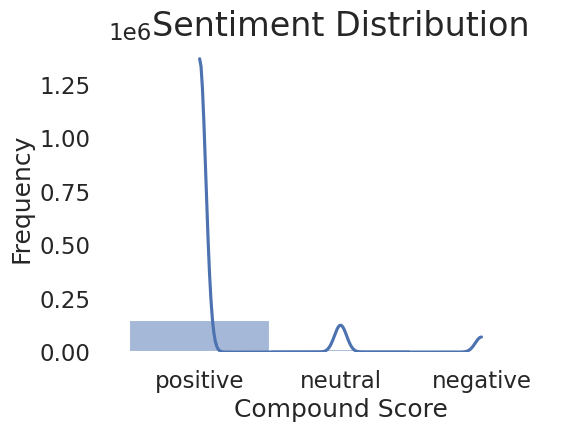

In [ ]:
# Visualise the result

# Import packages
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more specific style
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6,4))

# Use histplot
sns.histplot(x="sentiment_cat",
             data=myData,
             # kernal density estimation
             kde=True,
             # control the bin width
             binwidth=0.02
             )

# Add label to horiztontal axis
ax.set_xlabel("Compound Score")

# Remove ylabel
ax.set_ylabel("Frequency")

# Add a title
ax.set_title("Sentiment Distribution", fontsize = 24)

# Remove the border line
sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig("sentDist.png",
            bbox_inches="tight",
            dpi=200)

# Show nicely in the notebook
plt.show()

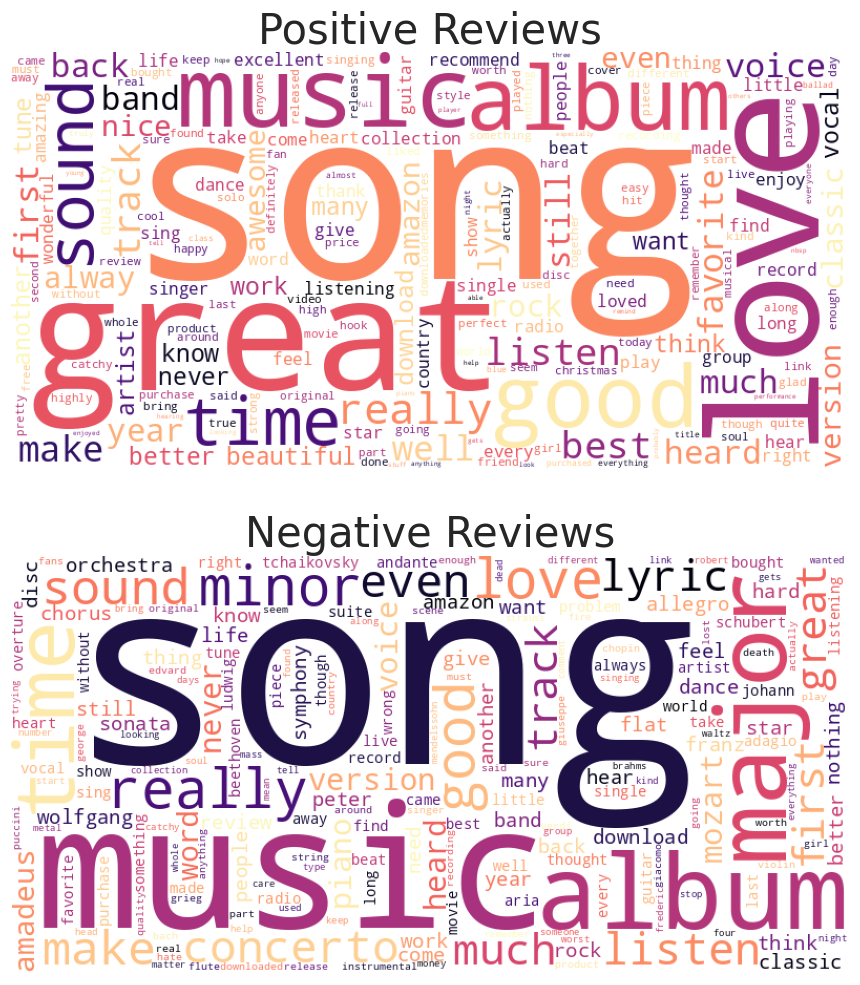

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set up the matplotlib figure
f, ax = plt.subplots(2, 1, figsize=(12,12))

# Generate a word cloud for positive reviews
myCloudPos = WordCloud(random_state=9165,
                       width=800, height=400,
                       # collocations=True will include 2 words/bigrams
                       collocations=False,
                       background_color='white',
                       colormap='magma'
                       ).generate(myStringPos)

ax[0].imshow(myCloudPos)
ax[0].set_title('Positive Reviews', fontsize=30)
ax[0].set_xlabel('')
ax[0].axis("off")

# Generate a word cloud for negative reviews
myCloudNeg = WordCloud(random_state=9165,
                       width=800, height=400,
                       # collocations=True will include 2 words/bigrams
                       collocations=False,
                       background_color='white',
                       colormap='magma'
                       ).generate(myStringNeg)

ax[1].imshow(myCloudNeg)
ax[1].set_title('Negative Reviews', fontsize=30)
ax[1].set_xlabel('')
ax[1].axis("off")

# Save the figure
plt.savefig('conditionalWordcloud.png',
            bbox_inches='tight',
            dpi=400)

# Show nicely in the notebook
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# First upload a review data set to the runtime

# Initiate an empty list to store sliced dataframes (chunks)
myList = []

# Specify the chunksize
chunksize = 10000

# nrows should be more than the total number of rows in the whole file
for chunk in pd.read_json('Digital_Music_5.json', nrows=10000000, lines=True,  chunksize=chunksize):
    myList.append(chunk)

# put the chunks together
myData = pd.concat(myList,axis=0)

In [ ]:
# Use regular expression

import re

# Get a bunch of tools from nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Create an empty list to store the cleaned reviews
cleaned_review = []

# Tidy up the reviews

for review in myData['reviewText'].apply(str):
  # Remove special characters
  review = re.sub("[^a-zA-Z']"," ",review)
  #Remove leading and trailing whitespaces
  review = review.strip()
  #Restrict the length of the string
  if len(review) > 5:
    cleaned_review.append(review)

In [ ]:
# Concatenate all the reviews into a single string
all_review = ' '.join(cleaned_review)

# Tokenise into words
myWords = word_tokenize(all_review)

# Need a dictionary of stop words
en_stopwords = set(stopwords.words('english'))

# Remove stop words
# Only keep words with more than 3 letters
# Lowercase the words
myWords_noSW_noCase = [word.lower() for word in myWords if (word.lower() not in en_stopwords) and (len(word)>3)]

# Count word frequency with the cleaned set
fDist = FreqDist(myWords_noSW_noCase)

# Take a look
fDist.most_common(30)

[('song', 104390),
 ('great', 48540),
 ('love', 46988),
 ('music', 39340),
 ('like', 31992),
 ('album', 29021),
 ('good', 28656),
 ('songs', 26339),
 ('really', 15393),
 ('time', 14245),
 ('would', 11793),
 ('listen', 11457),
 ('best', 11425),
 ('sound', 10321),
 ('well', 9741),
 ('first', 9724),
 ('heard', 9608),
 ('back', 9388),
 ('much', 8950),
 ('still', 8899),
 ('voice', 8694),
 ('classic', 7955),
 ('lyrics', 7868),
 ('band', 7728),
 ('always', 7562),
 ('favorite', 7551),
 ('even', 7341),
 ('rock', 7247),
 ('track', 7190),
 ('amazon', 6922)]

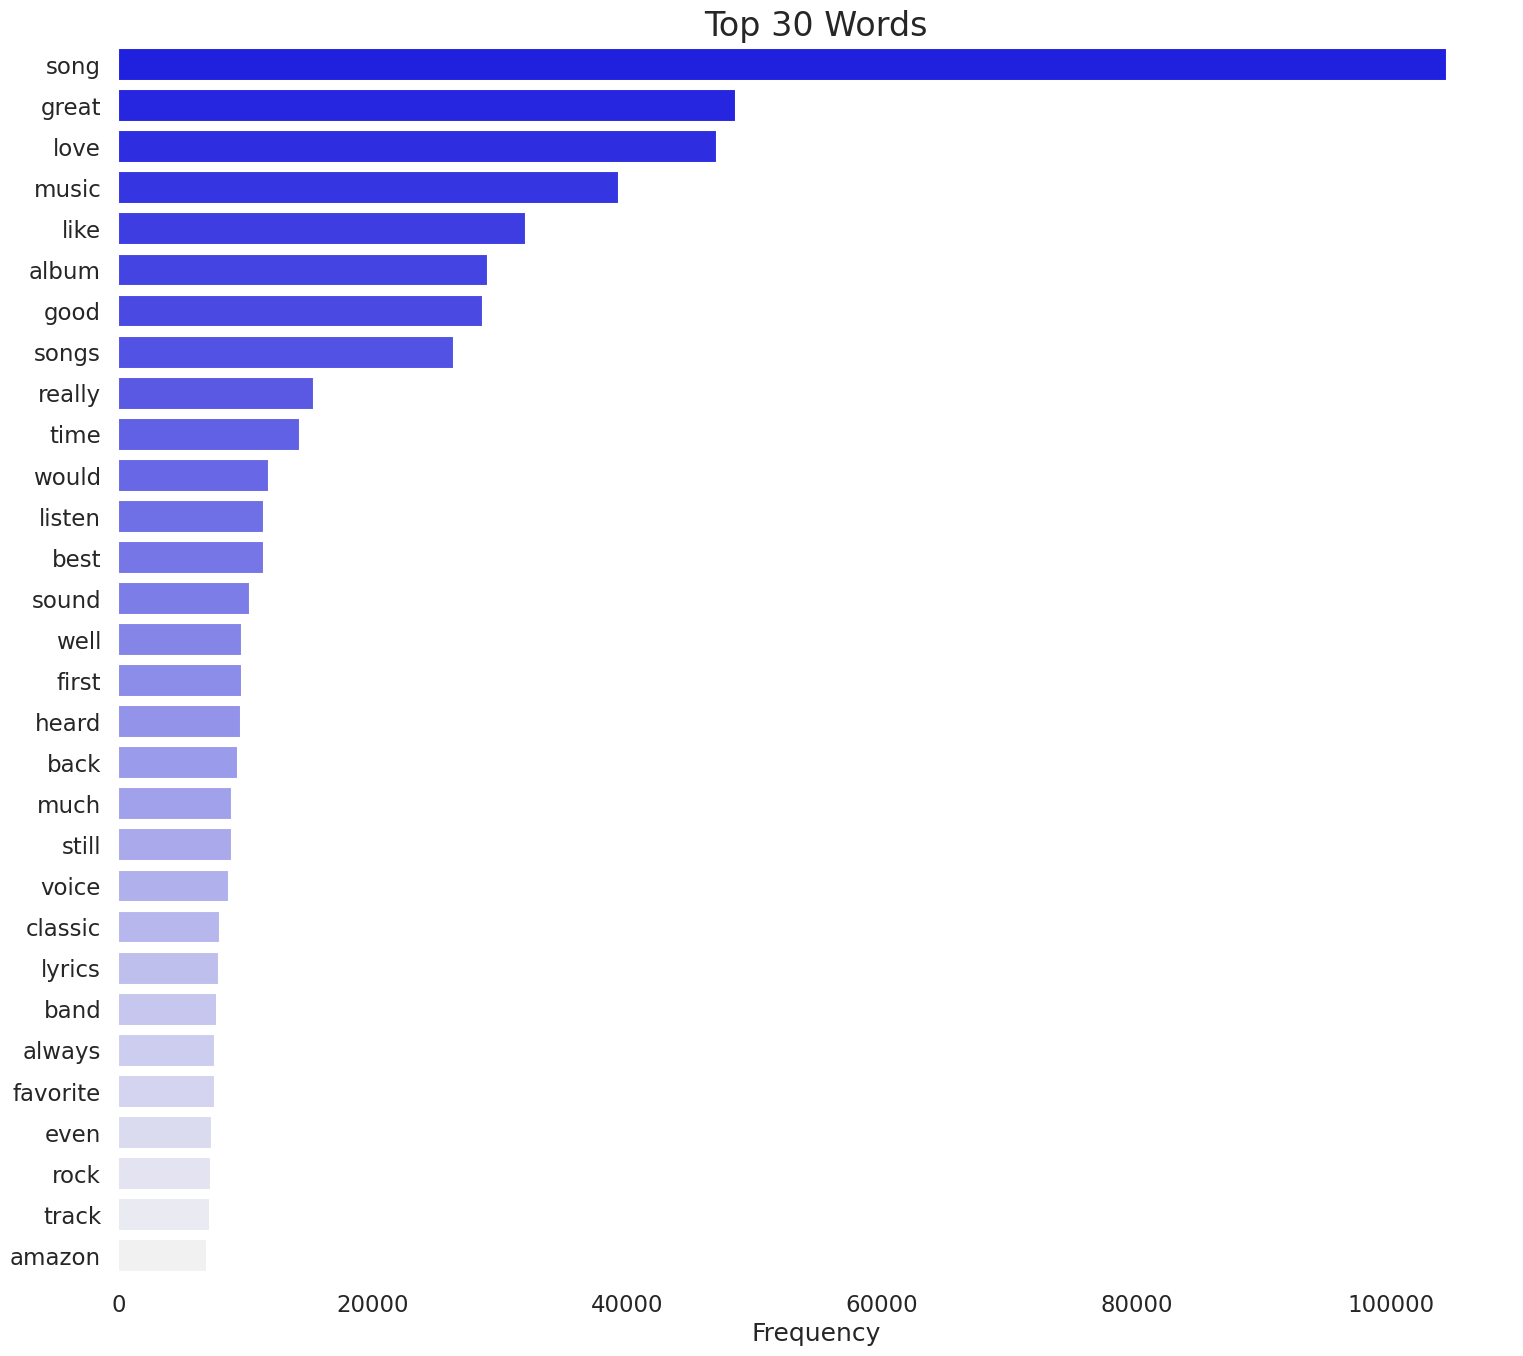

In [ ]:
# Visualise the result

# Convert the result to a dataframe for visualisation
myDF = pd.DataFrame(fDist.most_common(30), columns=['word', 'frequency'])

# Set a more specific style
sns.set_theme(style="white", context="talk")
#sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,16))


# Define the base color as a yellow color in hexadecimal format
baseColor = "blue"

# Create a palette with 8 shades of the base color, ranging from bright to light
yellowPalette = sns.light_palette(baseColor, n_colors=30, reverse=True)

# x and y will control if the barplot is horizontal or vertical
sns.barplot(x="frequency",
            y="word",
            data=myDF,
            palette=yellowPalette  # Use the yellow color palette
            )

# Add label to horiztontal axis
ax.set_xlabel("Frequency")

# Remove ylabel
ax.set_ylabel("")

# Add a title
ax.set_title("Top 30 Words", fontsize = 24)

# Remove the border line
sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig("top20.png",
            bbox_inches="tight",
            dpi=200)

# Show nicely in the notebook
plt.show()